In [5]:
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
from pylab import rcParams
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
from prettytable import PrettyTable

rcParams['figure.figsize'] = 7, 4
rcParams['figure.dpi'] = 120
rcParams.update({'font.size': 10})


In [50]:
# Load the results
with open("results/results_variable_dataseed.json", "r") as f:
    var_dataseed = json.load(f)
    
with open("results/results_variable_netseed.json", "r") as f:
    var_netseed = json.load(f)

In [51]:
# Function to plot multiple configurations in one plot
def plot_multiple(keys, labels):
    for key, label in zip(keys, labels):
        scores = np.array(var_dataseed[key])
        scores = scores[np.where(scores)][:20]
        x = np.linspace(1, 20, 20)
        mean = np.round(np.mean(scores), 4)
        std = np.round(np.std(scores),4)
        plt.plot(x, scores, label=f"{label}: {mean}({std})")
    plt.ylim([0.35, 0.9])
    plt.xlabel("Seed number")
    plt.ylabel("MCC")
    plt.legend()
    plt.xticks([i for i in range(0, 21, 5)])
    plt.show()

In [52]:
# Functin to plot multiple the same configuration from 
# two different dictionaries (seed fixing methods) in one plot
def plot_multiple_seeds(key, datas, labels):
    for data, label in zip(datas, labels):
        scores = np.array(data[key])
        scores = scores[np.where(scores)][:20]
        x = np.linspace(1, 20, 20)
        mean = np.round(np.mean(scores), 4)
        std = np.round(np.std(scores),4)
        plt.plot(x, scores, label=f"{label}: {mean}({std})")
    plt.ylim([0.35, 0.9])
    plt.xlabel("Seed number")
    plt.ylabel("MCC")
    plt.legend()
    plt.xticks([i for i in range(0, 21, 5)])
    plt.show()

# Reproducing results
Now lets show the average MCC score along with std for each different configuration on the first 20 seeds.

In [53]:
def pretty_print_results(var_dataseed, var_netseed):
    t = PrettyTable(['Network', 'Flow network', "implementation of \u03BB(u)", "dataset size", "fixed random seed", "average MCC", "std"])
    for i, datadict in enumerate([var_dataseed, var_netseed]):
        for key in datadict:
            key_list = key.split("_")
            net = key_list[0]
            if net == "iVAE":
                data_size = key_list[1]
                flow_net = "-"
                natural_param = "-"
            else:
                data_id = 3
                natural_param = key_list[1]
                if natural_param == "fixed":
                    natural_param = "Softplus only on \u03BE"
                elif natural_param == "removed":
                    net = "Flow"
                flow_net = key_list[2]
                if flow_net != "PlanarFlow":
                    flow_net += "_" + key_list[3]
                    data_id += 1                
                data_size = key_list[data_id]
                
            seed = "network" if i==0 else "data"
            scores = np.array(var_dataseed[key])
            scores = scores[np.where(scores)][:20]
            mcc = np.round(np.mean(scores),4)
            std = np.round(np.std(scores),4)
            t.add_row([net, flow_net, natural_param, data_size, seed, mcc, std])
            
    print(t)
pretty_print_results(var_dataseed, var_netseed)

+---------+--------------+------------------------+--------------+-------------------+-------------+--------+
| Network | Flow network | implementation of λ(u) | dataset size | fixed random seed | average MCC |  std   |
+---------+--------------+------------------------+--------------+-------------------+-------------+--------+
|   iVAE  |      -       |           -            |     1000     |      network      |    0.4701   | 0.0726 |
|  iFlow  |   RQNSF_AG   |   Softplus only on ξ   |     1000     |      network      |    0.7499   | 0.0804 |
|   Flow  |   RQNSF_AG   |        removed         |     1000     |      network      |    0.6446   | 0.0638 |
|  iFlow  |   RQNSF_AG   |        original        |     1000     |      network      |    0.7131   | 0.0585 |
|  iFlow  |   RQNSF_AG   |        original        |    10000     |      network      |    0.735    | 0.0619 |
|   iVAE  |      -       |           -            |    10000     |      network      |    0.4899   | 0.0481 |
|  iFlow  

## Performance comparison plots
Now we will compare the MCC scores along the seeds between iVAE and different configurations of iFlow. 


First lets plot regular iFlow against iVAE

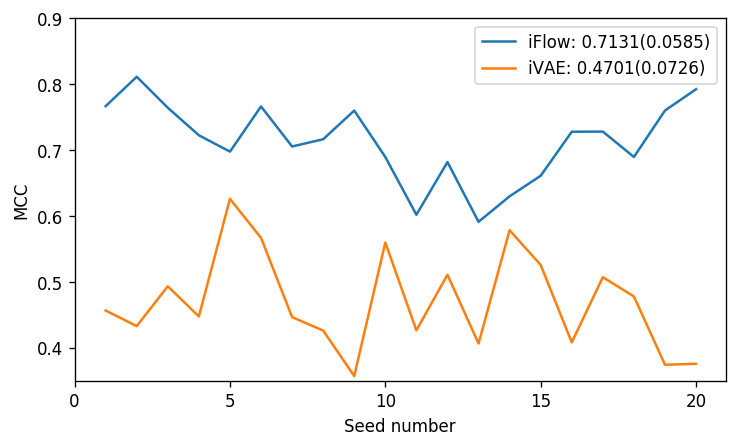

In [54]:
plot_multiple(["iFlow_original_RQNSF_AG_1000", "iVAE_1000"], ["iFlow", "iVAE"])

Now lets also compare an altered version of iFlow model to iVAE. In the original code implementation of the authors there is a comment hinting towards an improvement to the model implementation.
This "fixed" iFlow model, where the softplus activation is only applied on the $\xi$'s the $\lambda(u)$ network, instead of (unnecessarily) over both the $\xi$'s and the $\eta$'s. This possibly allows for more expressivity. 

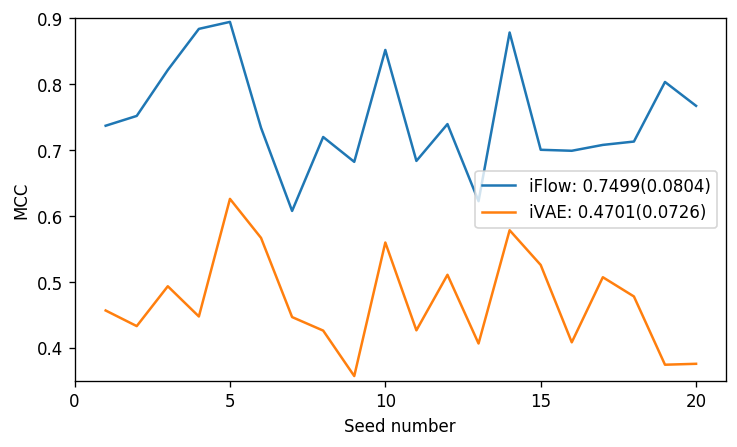

In [55]:
plot_multiple(["iFlow_fixed_RQNSF_AG_1000", "iVAE_1000"], ["iFlow", "iVAE"])

The paper only varies the random seed of the data, while fixing the random seed of the model itself itself. This could result in biased results, if the model seed is exceptionally good. Therefore we also provide the results of doing the reverse, to determine whether this had a significant impact.

First we do this for the training of iFlow:

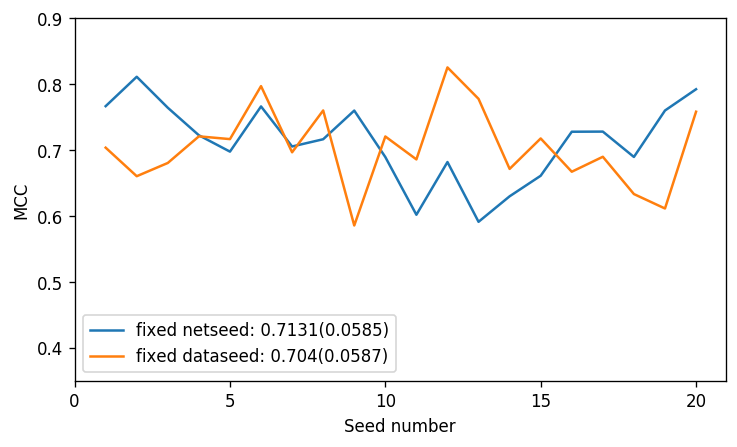

In [56]:
plot_multiple_seeds("iFlow_original_RQNSF_AG_1000", [var_dataseed, var_netseed], ["fixed netseed", "fixed dataseed"])

And for iVAE

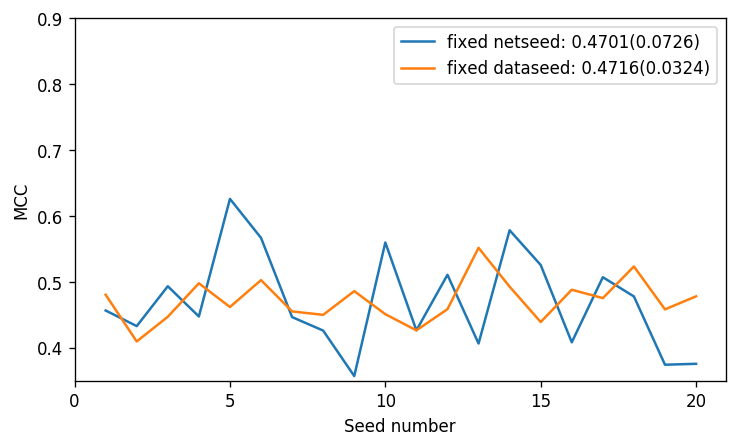

In [57]:
plot_multiple_seeds("iVAE_1000", [var_dataseed, var_netseed], ["fixed netseed", "fixed dataseed"])

Finally, due to the great difference in complexity between the author's implementation of iFlow and iVAE (3M and 18k parameters respectively) we have created and tested an additional iFlow model, which instead of the large RQNSF AG cubic Spline Flow model uses a relatively small Planar Flow model. This results in 2k and 18k parameters for iFlow with PlanarFlow and iVAE respectively.

Furthermore, since the authors provide no comparison as to how iFlow compares to regular Flow we also test versions of both the iFlow with PlanarFlow and iFlow with SplineFlow with the identifiability-ensuring aspect disabled, effectively resulting in regular PlanarFlow and SplineFlow models.

First we plot the two SplineFlow models against iVAE

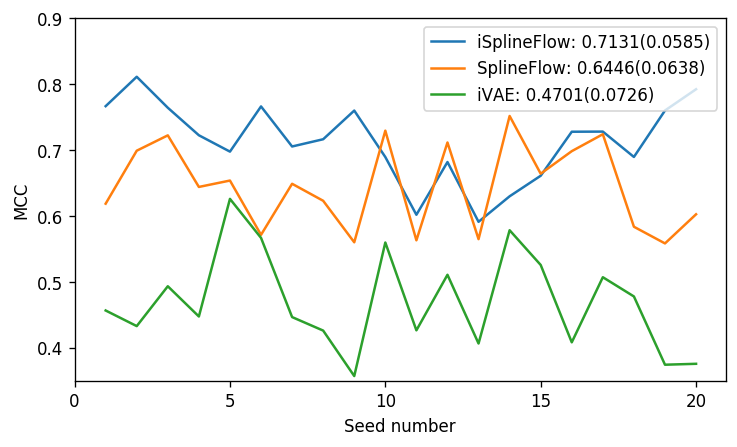

In [58]:
plot_multiple(["iFlow_original_RQNSF_AG_1000", "iFlow_removed_RQNSF_AG_1000", "iVAE_1000"], ["iSplineFlow", "SplineFlow", "iVAE"])

And then the two PlanarFlow models

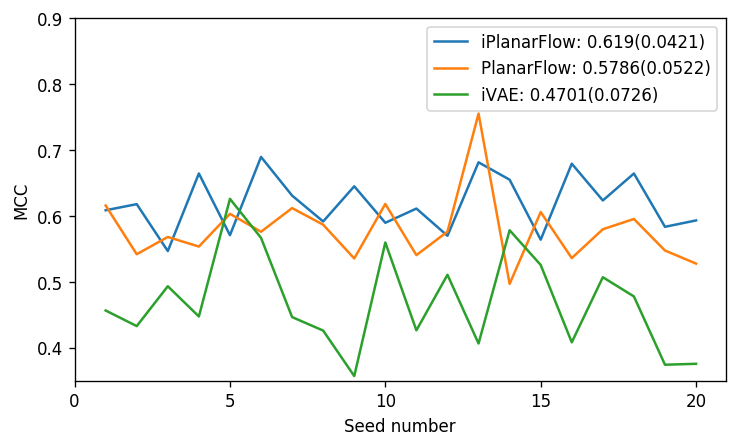

In [59]:
plot_multiple(["iFlow_original_PlanarFlow_1000", "iFlow_removed_PlanarFlow_1000", "iVAE_1000"], ["iPlanarFlow", "PlanarFlow", "iVAE"])

## Testing some pre-trained models
We also provide two pre-trained models, one for both the default iFlow and the iVAE implementation. Both models are trained on a random seed of 1 for the model training and the data generation. Here we will test the performance of these networks on the data.

First lets do some imports and lets load the data used to train these models

In [73]:
from lib.data import SyntheticDataset
from lib.models import iVAE
from lib.iFlow import iFlow
from torch.utils.data import DataLoader
from lib.metrics import mean_corr_coef as mcc

In [128]:
dset = SyntheticDataset("data/1/tcl_1000_40_5_5_3_1_gauss_xtanh_u.npz", 'cpu');
data_dim, latent_dim, aux_dim = dset.get_dims();

data/1/tcl_1000_40_5_5_3_1_gauss_xtanh_u.npz
data loaded on cpu


Next we load the two pre-trained models

In [111]:
# Loading model state dict and arguments
iVAE_dict = torch.load("trained_models/iVAE_1000_1_1.pt")
iVAE_args = iVAE_dict["args"]
iVAE_args.batch_size = batch_size

# Initializing iVAE model
ivae = iVAE(latent_dim, 
            data_dim, 
            aux_dim, 
            n_layers=iVAE_args.depth, 
            activation="lrelu", 
            device='cpu', 
            hidden_dim=iVAE_args.hidden_dim, 
            anneal=iVAE_args.anneal)

# Loading state of pre-trained model into newly created model.
ivae.load_state_dict(iVAE_dict["model_state_dict"])

<All keys matched successfully>

In [121]:
# Loading model state dict and arguments
iFlow_dict = torch.load("trained_models/iFlow_original_RQNSF_AG_1000_1_1.pt")
iFlow_args = vars(iFlow_dict["args"])

# Update arguments
iFlow_args.update(dset.get_metadata())
iFlow_args.update({"train_latent_dim": iFlow_args["latent_dim"]})
iFlow_args.update({"device": 'cpu'})

# Initialize new model and store saved state.
iflow = iFlow(args=iFlow_args)
iflow.load_state_dict(iFlow_dict["model_state_dict"])

<All keys matched successfully>

And a function to evaluate a model on a certain metric.

In [122]:
def eval_model(model, metric, dataloader):
    z_est_list = []
    z_list = []
    
    for x, u, z in dataloader:
        # Model inference
        if isinstance(model, iVAE):
            _, z_est = model.elbo(x, u)
        else:
            z_est, _ = model.inference(x, u)
            
        z_est_list.append(z_est.cpu().detach().numpy())
        z_list.append(z)
        
    z_est = np.concatenate(z_est_list)
    z = np.concatenate(z_list)
    # Computing metric score
    perf = np.round(metric(z, z_est), 4)
    return perf

And now we evaluate the two pre-trained models based on MCC score.

In [123]:
testloader = DataLoader(dset, shuffle=False, batch_size=iFlow_args['batch_size'], num_workers=0, pin_memory=True)
iflow_perf = eval_model(iflow, mcc, testloader)
print(f"iFlow MCC score: {iflow_perf}")

iFlow MCC score: 0.6979


In [124]:
testloader = DataLoader(dset, shuffle=False, batch_size=iVAE_args.batch_size, num_workers=0, pin_memory=True)
ivae_perf = eval_model(ivae, mcc, testloader)
print(f"iVAE MCC score: {ivae_perf}")

iVAE MCC score: 0.4658


## Visualizing the difference between iFlow and  Flow
To understand illustrate the practical advantages and differences between iFlow and Flow both models are applied on the half-moon dataset. Both Flow models use RealNVP as the flow model, resulting in iRealNVP and regular RealNVP.

First we import both models, such that we can load the pre-trained models.

In [60]:
from lib.models import i_RealNVP, RealNVP, dist

Now we define two functions to visualize the performance of iRealNVP and "regular" RealNVP.

The first function visualizes the performance and seperability of the models by plotting the original data space of the half-moon dataset and then plotting the latent space after encoding using the model's $f$ function. Then it shows the generated latent space, and finally generated latent space after decoding it back to the original data space.

In [61]:
def plot_spaces(model):
    """
    Plots the original data (X) space of the half-moon dataset, the laten space after encoding,
    the generated latent space points and the decoded generated latent space in the original data space.
    
    input:
            model: the flow model, must be i_RealNVP or RealNVP
    """
    rcParams['figure.figsize'] = 20, 4

    # Generate synthetic data for the plots.
    noisy_moons, label = datasets.make_moons(n_samples=1000, noise=.05)
    u = torch.zeros((1000,2))
    l = torch.from_numpy(label)
    u[:,0] = l
    u[:,1] = 1-l
    label = label.astype(bool)

    # plot the original data X
    plt.subplot(141)
    x, y = datasets.make_moons(n_samples=1000, noise=.05)
    x = x.astype(np.float32)
    y = y.astype(bool)
    plt.scatter(x[y, 0], x[y, 1], c='r')
    plt.scatter(x[~y, 0], x[~y, 1], c='g')
    plt.title(r'$X \sim p(X)$')

    # plot the latent space after encoding the data using model.f(x, u)
    if isinstance(model, i_RealNVP):
        z = model.f(torch.from_numpy(noisy_moons.astype(np.float32)), u)[0].detach().numpy()
    else:
        z = model.f(torch.from_numpy(noisy_moons.astype(np.float32)))[0].detach().numpy()
    plt.subplot(142)
    plt.scatter(z[label, 0], z[label, 1], c='r')
    plt.scatter(z[~label, 0], z[~label, 1], c='g')
    plt.title(r'$z = f(X)$')

    # plot generated latent space points using the approximate prior distributions  
    plt.subplot(143)
    x0, x1, y0, y1 = model.sample(500)
    x0 = x0.detach().numpy()
    x1 = x1.detach().numpy()
    y0 = y0.detach().numpy()
    y1 = y1.detach().numpy()
    plt.scatter(y0[:, 0, 0], y0[:, 0, 1], c='r')
    plt.scatter(y1[:, 0, 0], y1[:, 0, 1], c='g')
    plt.title(r'$z \sim p(z)$')

    # plot the decoded generated latent space points in the orginal space.
    plt.subplot(144)
    plt.scatter(x0[:, 0, 0], x0[:, 0, 1], c='r')
    plt.scatter(x1[:, 0, 0], x1[:, 0, 1], c='g')
    plt.title(r'$X = g(z)$')
    plt.show()
    

This function shows a mapping between the entire latent space and the original data space.

In [64]:
def plot_latent2data(model):
    rcParams['figure.figsize'] = 20, 8
    
    if isinstance(model, i_RealNVP):
        # Calculating the spanned latent space by both Gaussians
        x0min = model.mu0[0] - 2.5 * model.s0[0,0]
        x0max = model.mu0[0] + 2.5 * model.s0[0,0]
        y0min = model.mu0[1] - 2.5 * model.s0[1,1]
        y0max = model.mu0[1] + 2.5 * model.s0[1,1]
        x1min = model.mu1[0] - 2.5 * model.s1[0,0]
        x1max = model.mu1[0] + 2.5 * model.s1[0,0]
        y1min = model.mu1[1] - 2.5 * model.s1[1,1]
        y1max = model.mu1[1] + 2.5 * model.s1[1,1]

        # Make a 6x6 grid of the latent space and sample n points unifrom in each quadrant. 
        xrange = (round(min(x0min, x1min).item(), 1), round(max(x0max, x1max).item(), 1))
        yrange = (round(min(y0min, y1min).item(), 1), round(max(y0max, y1max).item(), 1))
    
    else:
        # Make a 6x6 grid of the latent space and sample n points unifrom in each quadrant. 
        xrange = (-3,3)
        yrange = (-3,3)
        
    n = 200
    cycle = 6
    markers = ['o', '_', 'x', '|', '+', '*']
    alphas = [0.3, 1, 1, 1, 0.3, 0.8] 
    colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']
    block = []
    xstep = (xrange[1] - xrange[0]) / cycle
    ystep = (yrange[1] - yrange[0]) / cycle
    for i in np.linspace(xrange[0], xrange[1]-xstep, cycle):
        for j in np.linspace(yrange[0], yrange[1]-ystep, cycle):
            block.append((torch.FloatTensor(n).uniform_(i, i+xstep),
                          torch.FloatTensor(n).uniform_(j, j+ystep))) 


    # plot each quadrant in a separate color in y direction and separate symbol in x direction in the latent space. 
    plt.subplot(121)
    plt.title(r'$y \sim \mathcal{U}('+f'{xrange}'+', '+f'{yrange}'+')$')
    i = 0
    for x, y in block:
        plt.scatter(x, y, linewidths=0, c=colors[i%cycle], marker=markers[i//cycle], alpha=alphas[i//cycle])
        i += 1

    # plot each quadrant in a separate color in y direction and separate symbol in x direction in the original space. 
    plt.subplot(122)
    plt.title(r'$g(y)$')
    i = 0
    for x, y in block:
        z = model.g(torch.stack((x, y)).T).detach().numpy()
        plt.scatter(z[:,0], z[:,1], linewidths=0, c=colors[i%cycle], marker=markers[i//cycle], alpha=alphas[i//cycle])
        i += 1
    plt.show()

Now we load the pre-trained models

In [70]:
iFlow = torch.load("trained_models/iFlow_moon.pt")
iFlow.eval()
Flow = torch.load("trained_models/Flow_moon.pt")
Flow.eval();

And show the different spaces for iRealNVP (iFlow):

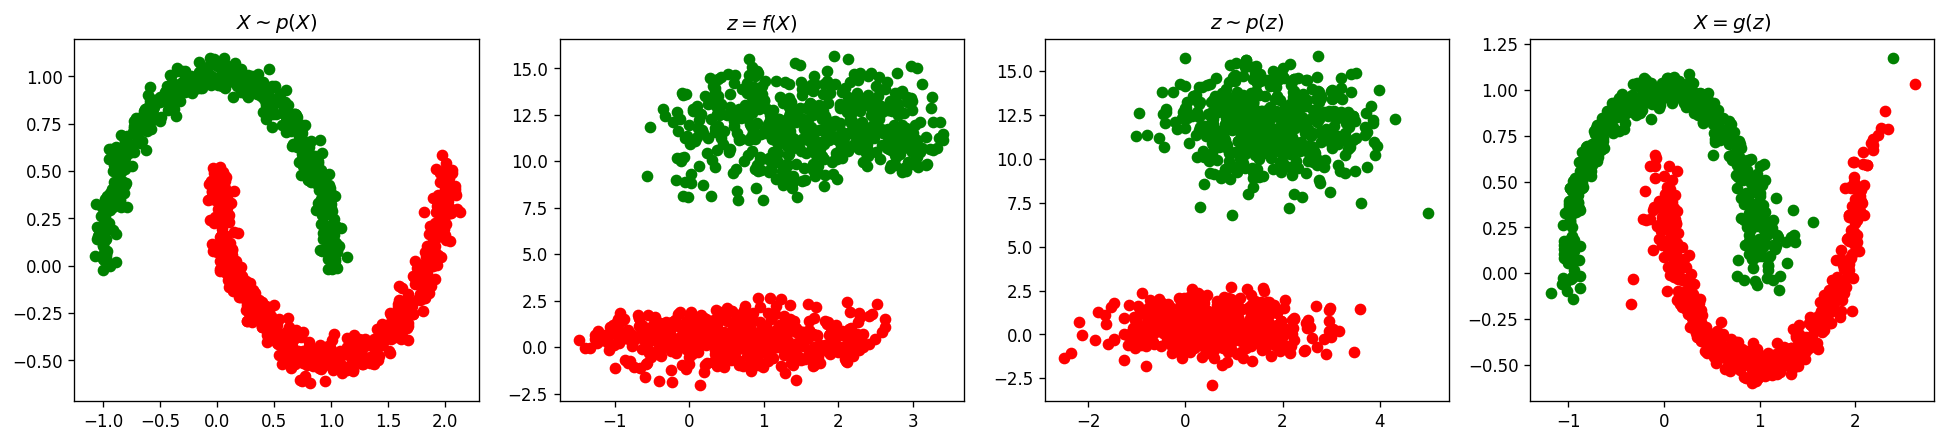

In [71]:
plot_spaces(iFlow)

And RealNVP (Flow): 

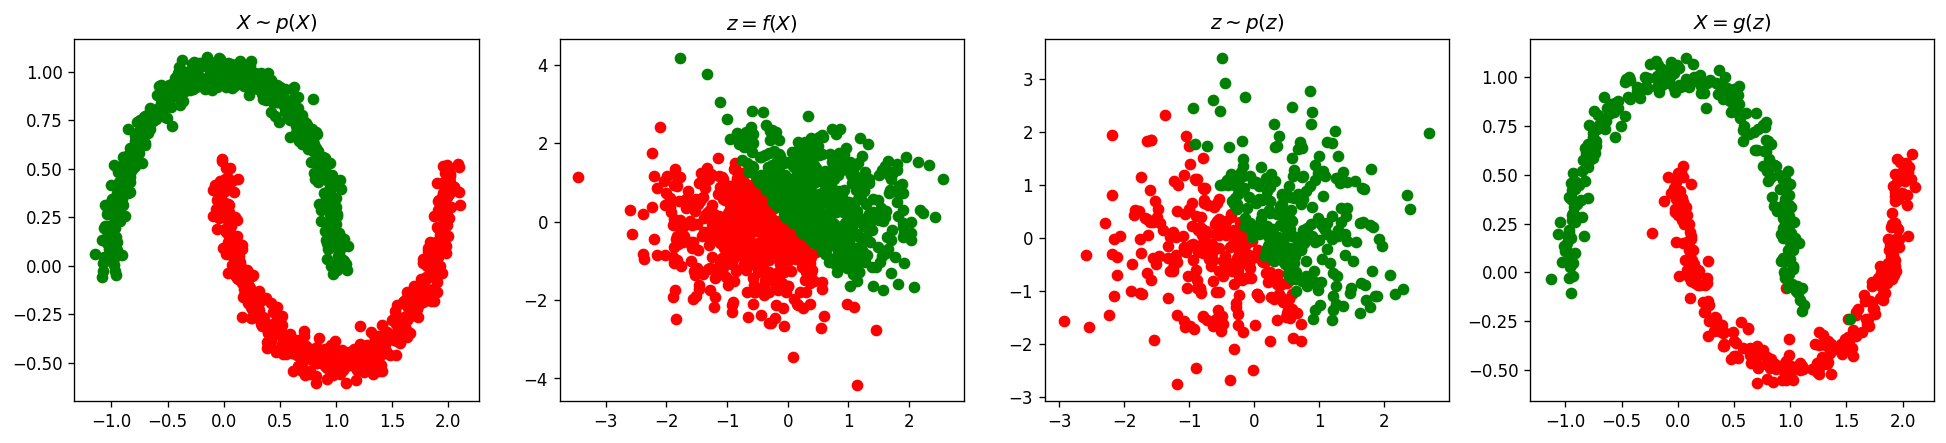

In [72]:
plot_spaces(Flow)

And the latent space exploration for iRealNVP (iFlow):

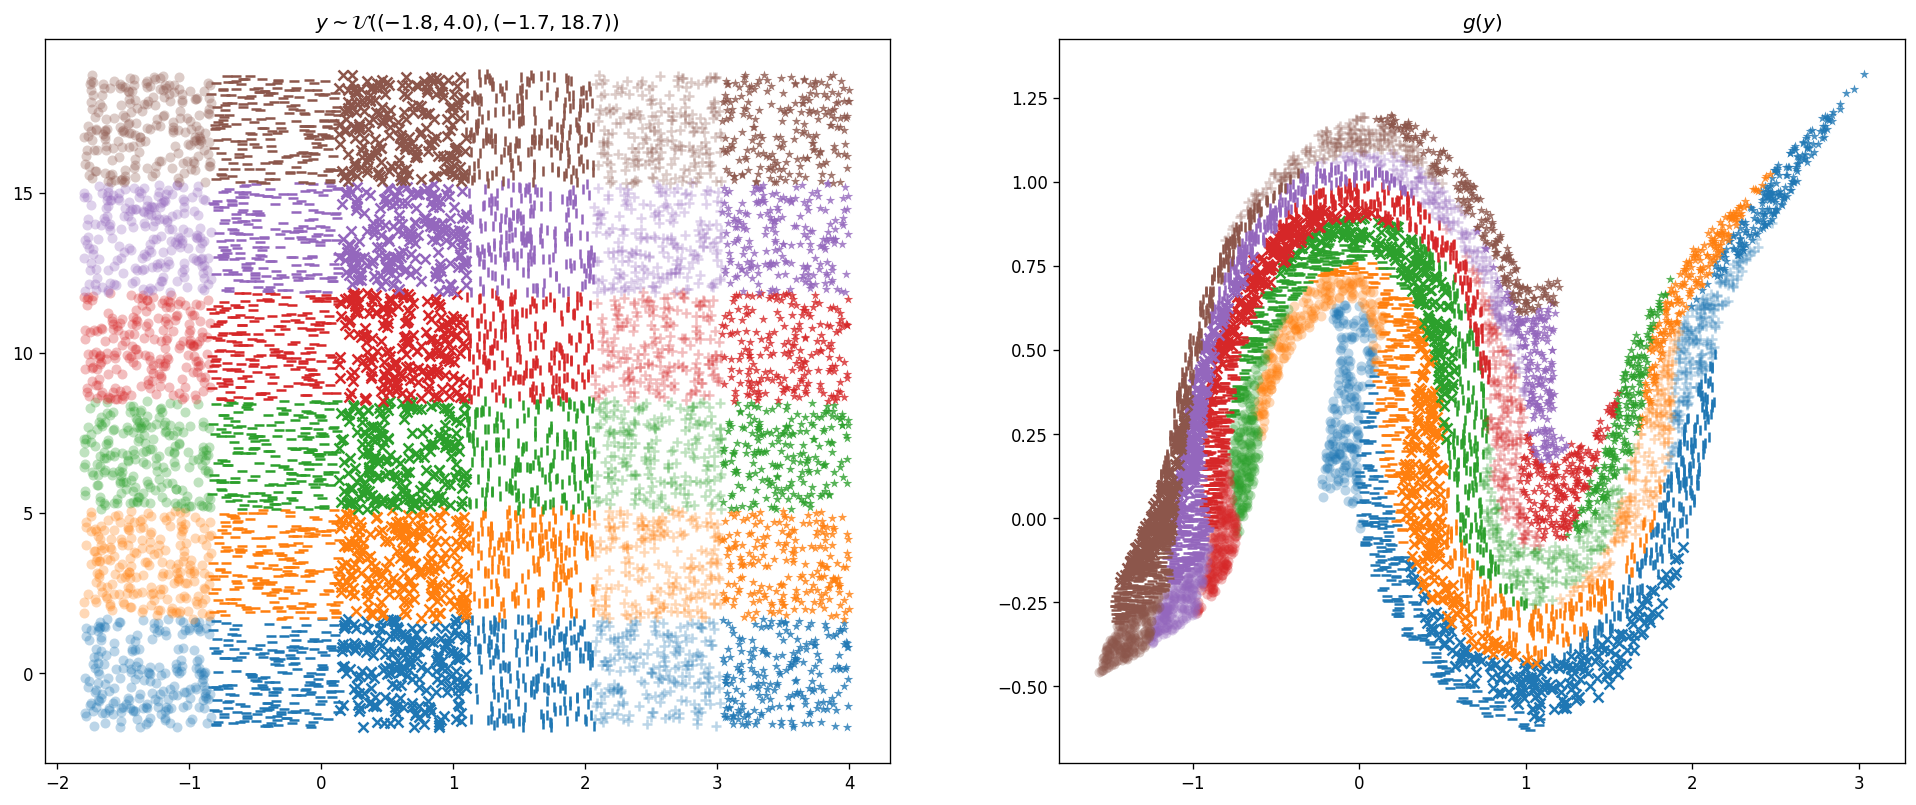

In [73]:
plot_latent2data(iFlow)

And for RealNVP (Flow)

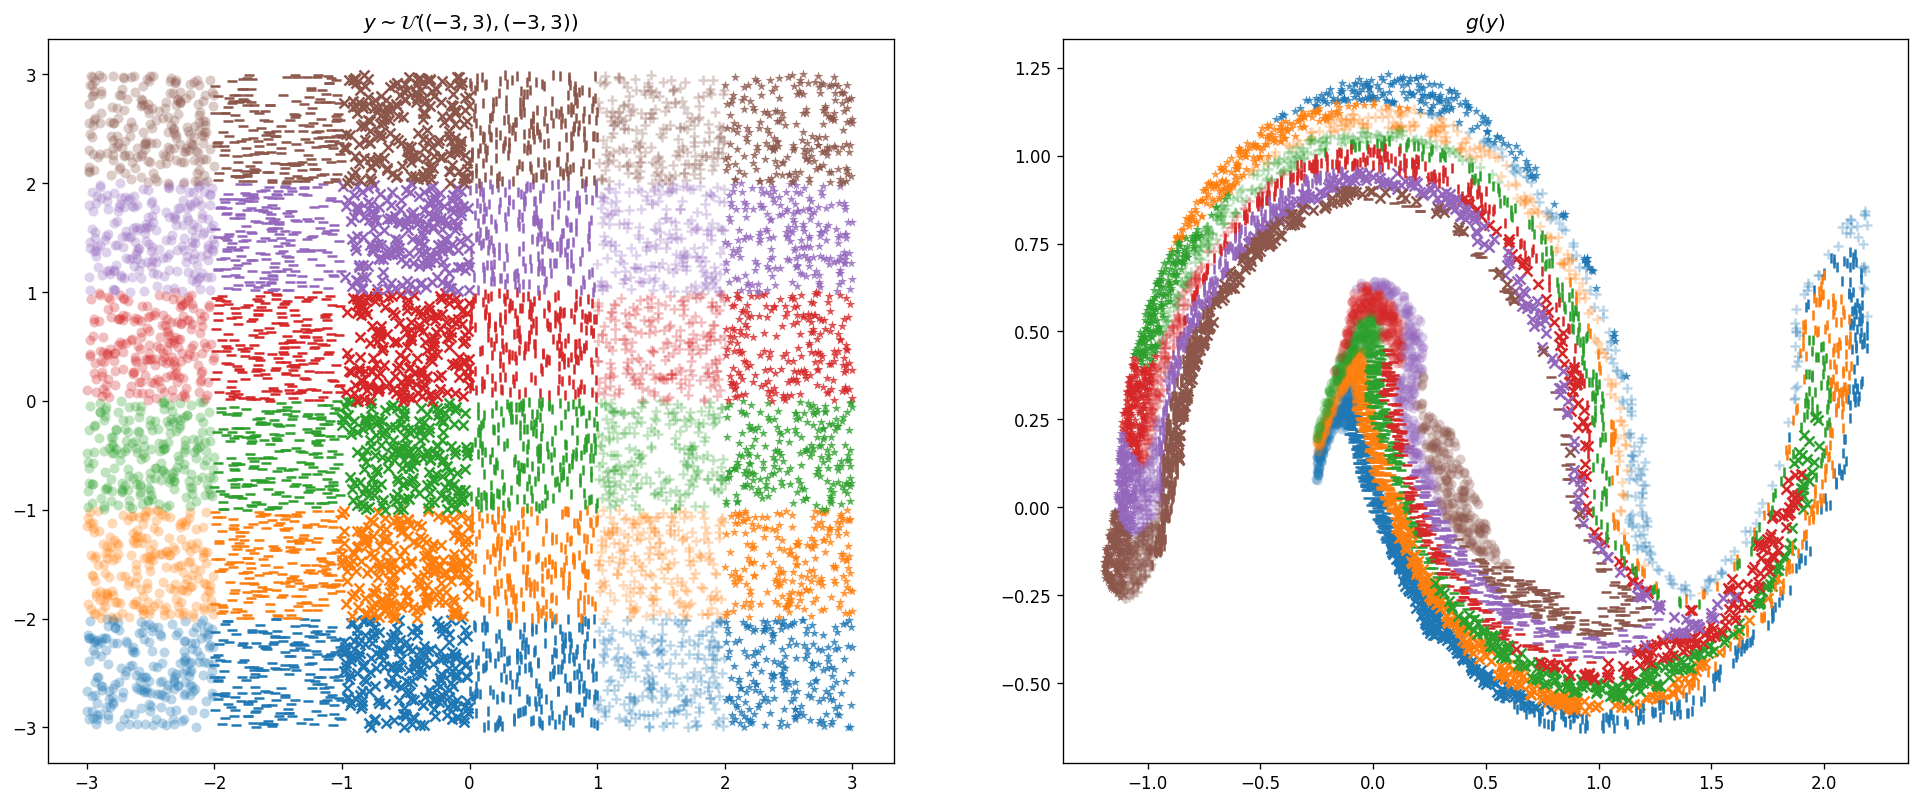

In [74]:
plot_latent2data(Flow)